# Выбор локации для скважины

<a id=0></a>
[Содержание](#0)

[1. Описание проекта](#1)

[2. Анализ данных](#2)

[3. Подготовка данных](#3)

[4. Обучение и проверка модели](#4)

[5. Подготовка к расчёту прибыли](#5)

[6. Расчёт прибыли и рисков](#6)

[7. Общий вывод](#7)

<a id=1></a>
## 1. Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Цель проекта:**

Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Данные:**

Данные геологоразведки трёх регионов находятся в файлах:
- [geo_data_0.csv](https://code.s3.yandex.net/datasets/geo_data_0.csv)
- [geo_data_1.csv](https://code.s3.yandex.net/datasets/geo_data_1.csv)
- [geo_data_2.csv](https://code.s3.yandex.net/datasets/geo_data_2.csv)

`id` — уникальный идентификатор месторождения;

`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

`product` — объём запасов в месторождении (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**План работы:**

1. Изучить данные и подготовить их к моделированию.

2. Обучить модель для каждого региона.

3. Составить функцию расчета прибыли в регионе.

4. Посчитать прибыль и риски за каждый регион и обосновать выбор региона.

5. Сделать выводы, оформить проект.

<a id=2></a>
[Содержание](#0)
## 2. Анализ данных

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

RND_STATE = 12012022

Загрузим каждый регион в отдельный датафрейм

In [3]:
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    df_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
try:
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
try:
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Вывод:**
    
В данных отсутсвуют пропуски.

<a id=3></a>
[Содержание](#0)
## 3. Подготовка данных

Удалим из каждого датафрейма столбец id. Он не несет значимости для для модели.

In [6]:
df_0 = df_0.drop(['id'], axis = 1)
df_1 = df_1.drop(['id'], axis = 1)
df_2 = df_2.drop(['id'], axis = 1)

Посмотрим граничные значения по столбцам

In [7]:
df_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [9]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Вывод:**
    
В 0 и 2 регионе средние значение объема в месторождении примерно одинаковые, значения mean и median одинаковые - 95.

В 1 регионе средние запасы нефти в месторождениях ниже, значения mean - 69, median - 57.

Посмотрим кол-во нулевых значений в `product` — объём запасов в месторождении.

In [10]:
print('Количество нулевых значений df_0[''product''] -', df_0[df_0['product'] == 0]['product'].count())
print('Количество нулевых значений df_1[''product''] -', df_1[df_1['product'] == 0]['product'].count())
print('Количество нулевых значений df_2[''product''] -', df_2[df_2['product'] == 0]['product'].count())

Количество нулевых значений df_0[product] - 1
Количество нулевых значений df_1[product] - 8235
Количество нулевых значений df_2[product] - 1


Посмотрим гистограммы по столбцу product по регионам, для этого напишем функцию `hist_oil`

In [12]:
def hist_oil(seria, bins, xlim_max, ylim_max, name_hist):

    plt.figure(figsize=[15, 8])
    plt.hist(seria, bins = bins)

    plt.xlim([0, xlim_max])
    plt.ylim([0, ylim_max])

    plt.title(name_hist)
    plt.xlabel('Объем нефти на скважину, тыс. барелей')
    plt.ylabel('Количество скважин')
    plt.show()

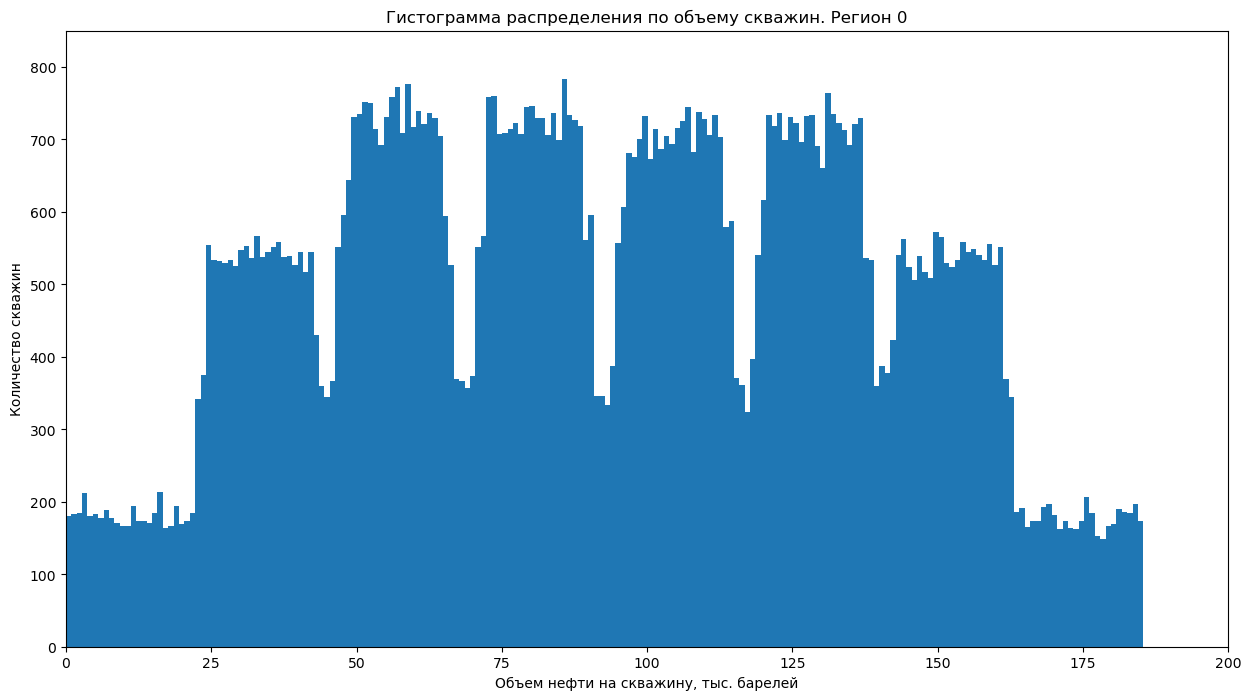

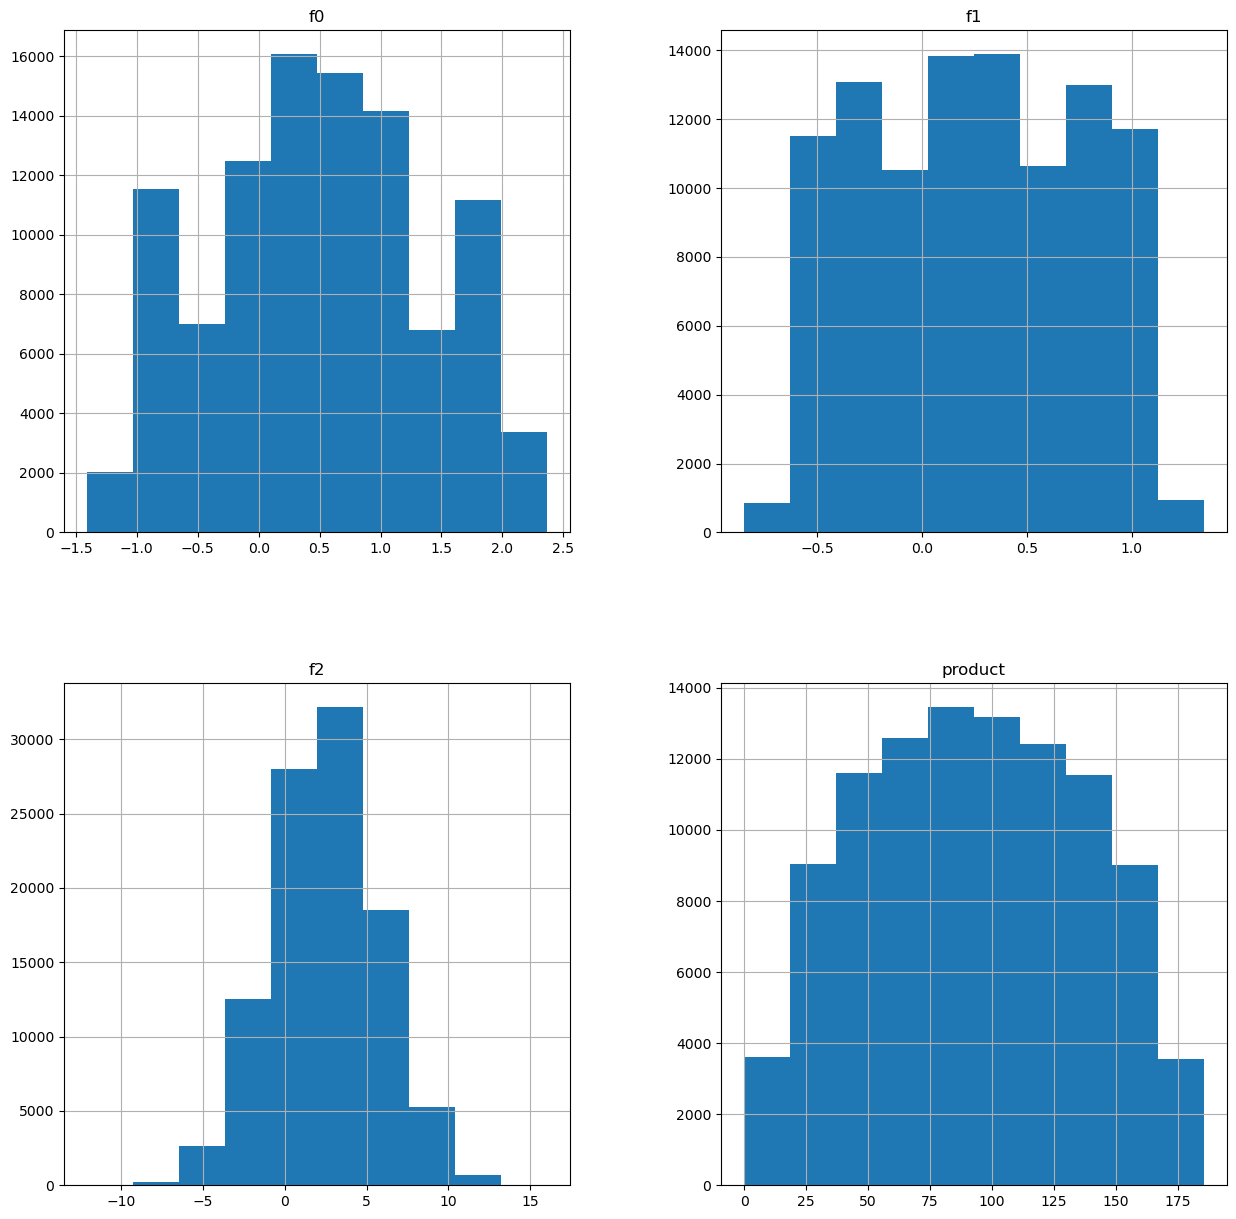

In [13]:
hist_oil(df_0['product'], 200, 200, 850, 'Гистограмма распределения по объему скважин. Регион 0')
df_0.hist(figsize = (15, 15))
plt.show()

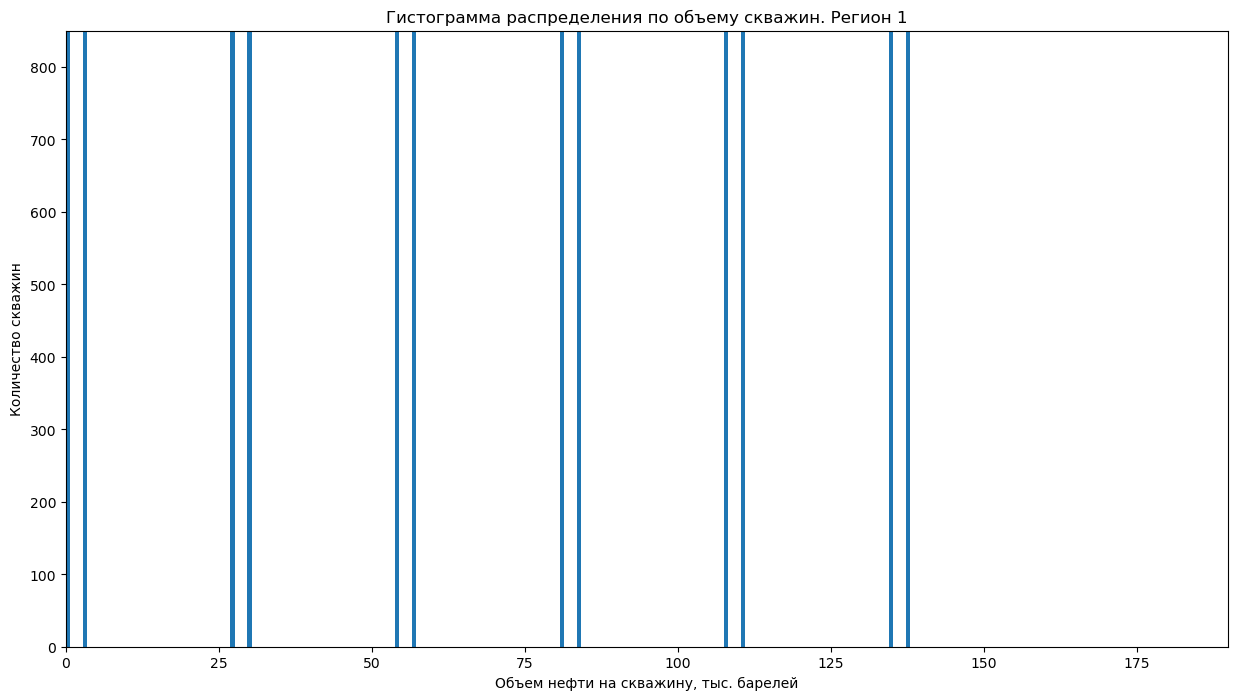

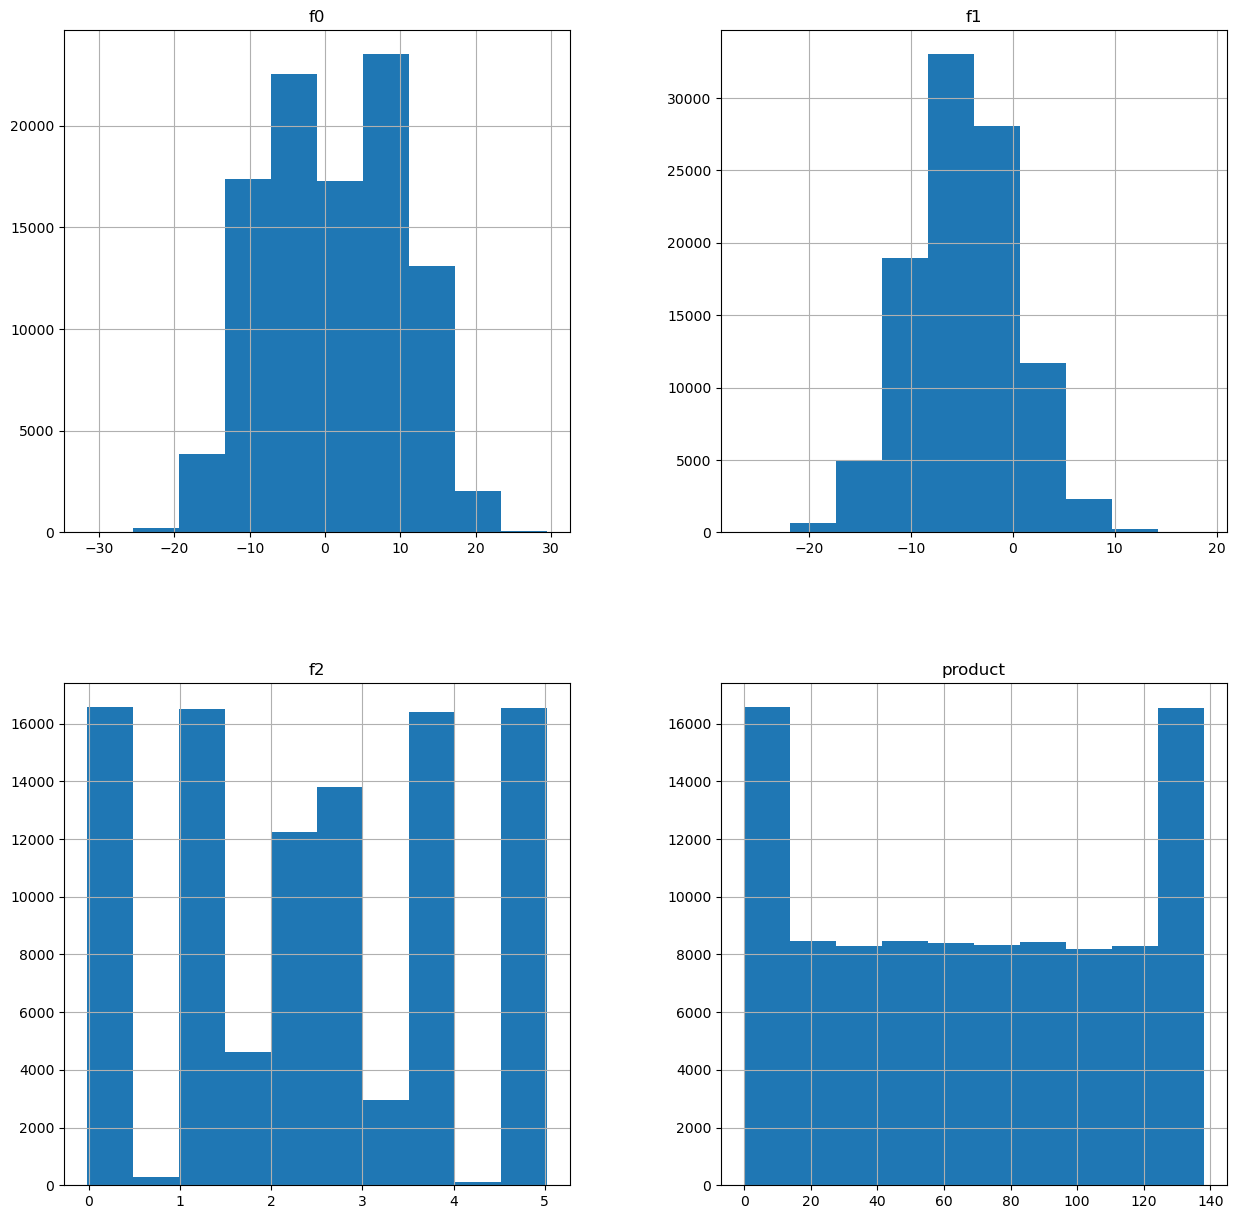

In [14]:
hist_oil(df_1['product'], 200, 190, 850, 'Гистограмма распределения по объему скважин. Регион 1')
df_1.hist(figsize = (15, 15))
plt.show()

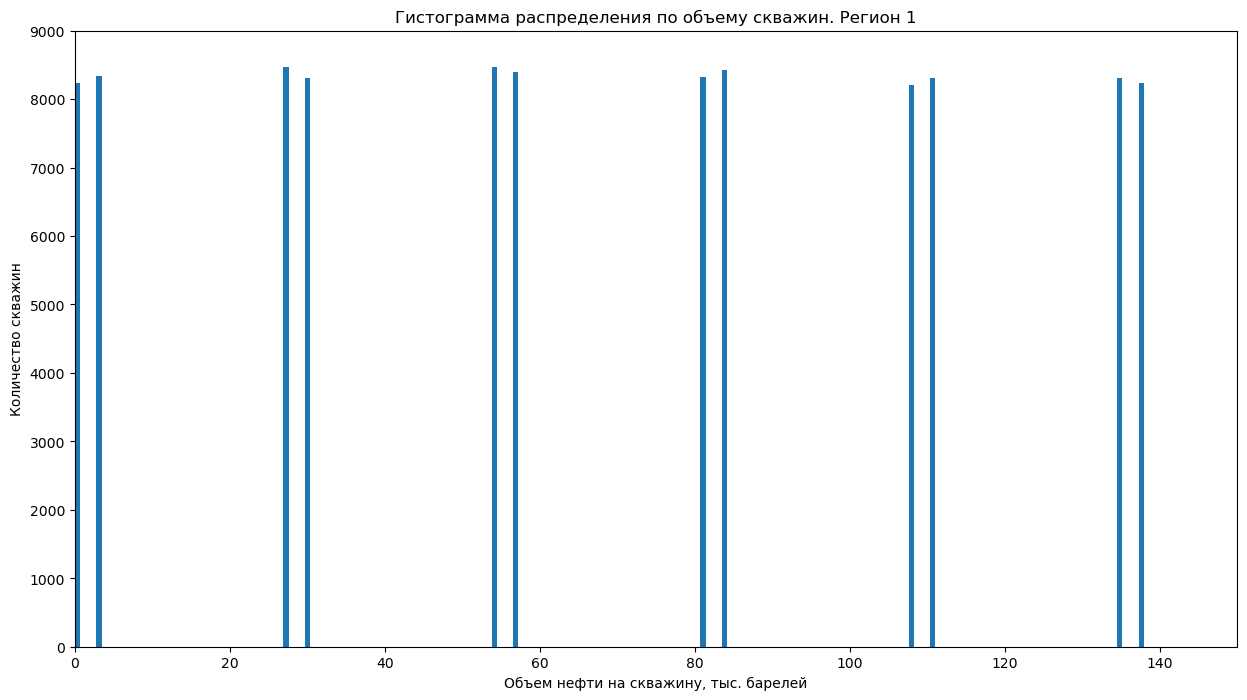

In [15]:
# Подберем масштаб
hist_oil(df_1['product'], 200, 150, 9000, 'Гистограмма распределения по объему скважин. Регион 1')

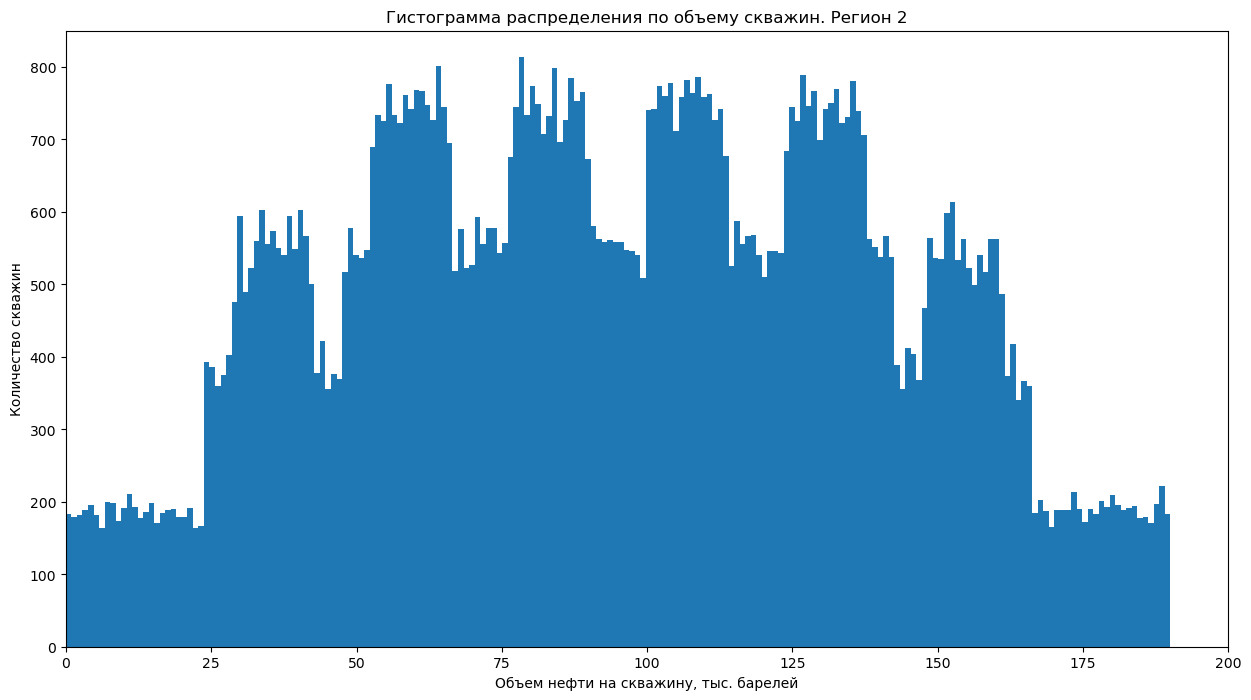

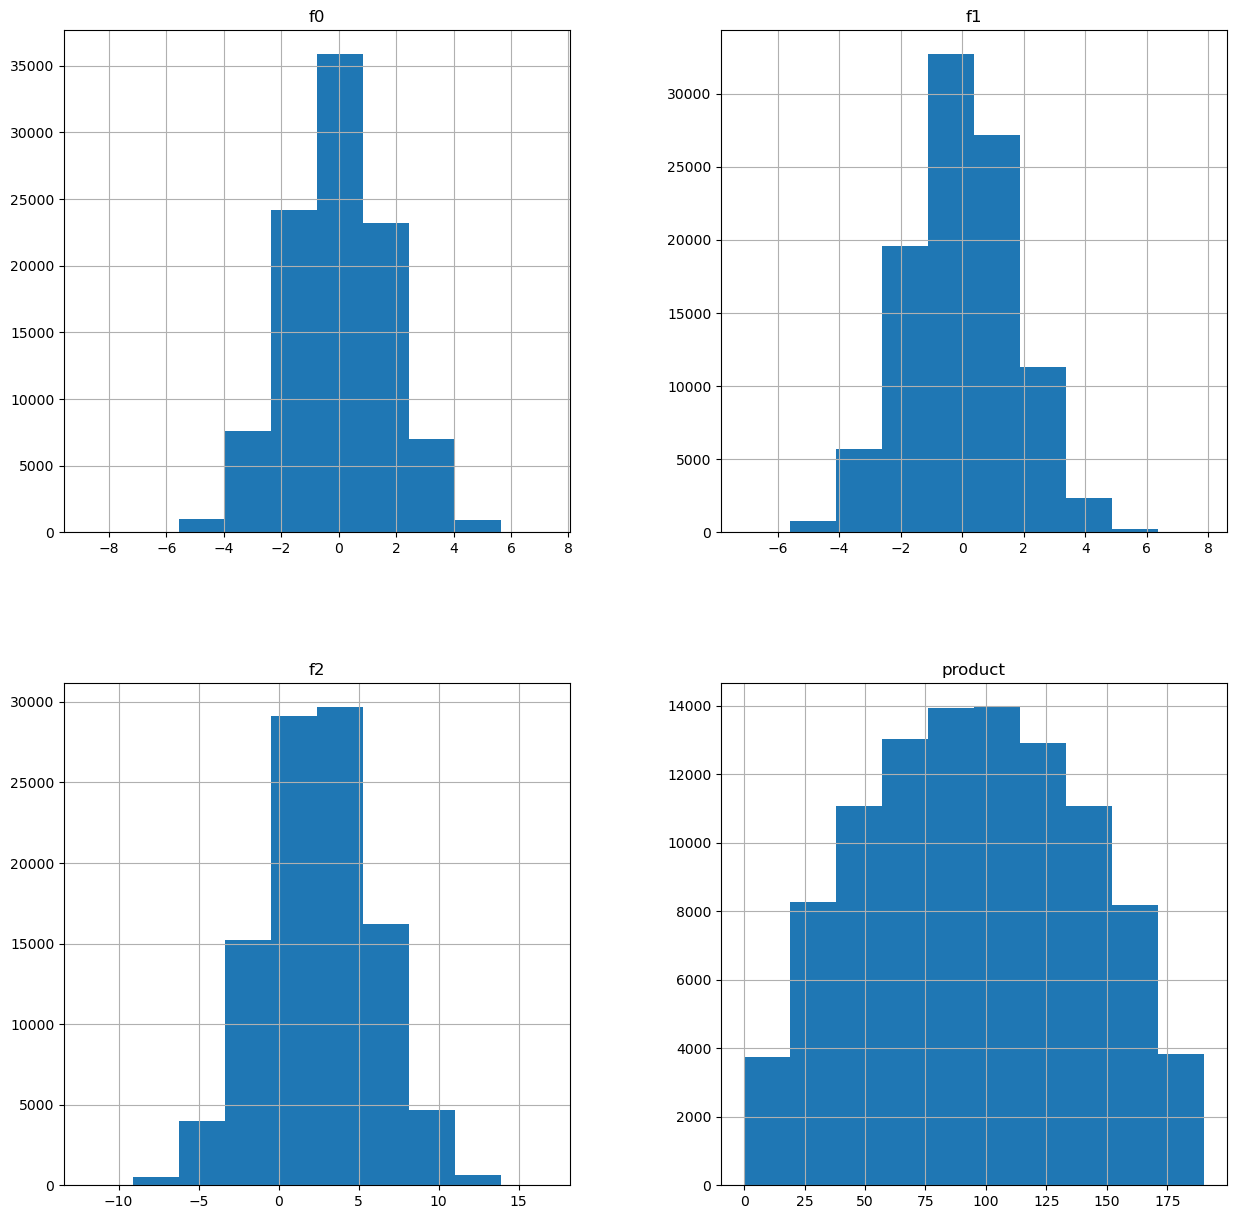

In [16]:
hist_oil(df_2['product'], 200, 200, 850, 'Гистограмма распределения по объему скважин. Регион 2')
df_2.hist(figsize = (15, 15))
plt.show()

In [17]:
display('Регион 0', df_0['product'].value_counts())
display('Регион 1', df_1['product'].value_counts())
display('Регион 2', df_2['product'].value_counts())

'Регион 0'

105.280062    1
122.799517    1
61.817308     1
37.155071     1
73.090084     1
             ..
154.694803    1
79.818082     1
138.609486    1
62.540393     1
149.633246    1
Name: product, Length: 100000, dtype: int64

'Регион 1'

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

'Регион 2'

27.758673     1
145.850966    1
51.061821     1
51.767755     1
127.557176    1
             ..
138.662027    1
171.123264    1
102.381336    1
140.622292    1
102.775767    1
Name: product, Length: 100000, dtype: int64

In [18]:
display('Регион 0', df_0.corr())
display('Регион 1', df_1.corr())
display('Регион 2', df_2.corr())

'Регион 0'

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


'Регион 1'

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


'Регион 2'

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Вывод:**

В 1 регионе около 8,2% месторождений не имеют значения в столбце `product`.

При сравнении с такими же значениями из 0 и 2 региона можно предположить, что данные были утеряны или месторождения не исследованы. По гистограммам можно увидеть, что у 0 и 2 региона распределение скважин близко к нормальному.

В 1 регионе данные имеют странное распределение: с шагом по 15-30 равномерно распределены 100000 значений. Данные не подчиняются закону больших чисел и похоже были введены искуственно.

Корреляция показывает, что данные в столбцах `f0` и `f1` слабо влияют на product, а вот `f2` положительно корелирует с `product`. Коэффициет корреляции `f2` равен 0,48 и 0,45 для регионов 0 и 2, а для региона 1 он равен 0,99.

Данные готовы к обучению.

In [19]:
# Для более тщательного EDA анализа можно использовать библиотеки sweetviz или pandas_profiling.
# Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям.
# Они просты в использоовании, на вход подается датафрейм: pandas_profiling.ProfileReport(df)
#!pip install pandas-profiling
#import pandas_profiling
#pandas_profiling.ProfileReport(df_0)

<a id=4></a>
[Содержание](#0)
## 4. Обучение и проверка модели

Создадим функцию разбивки датафреймов на 75% под тренировочные данные и 25% под валидационные

In [20]:
def split_df(df, target):
    df_x = df.drop([target] , axis=1)
    df_y = df[target]

    x_train, x_valid, y_train, y_valid = train_test_split(df_x, df_y, train_size = 0.75, random_state = RND_STATE)

    print('Размер тренерующей  выборки:', x_train.shape)
    print('Размер валидационной выборки:', x_valid.shape)
    display(df.head(3))
    
    return x_train, x_valid, y_train, y_valid

In [21]:
print('Регион 0')
x_0_train, x_0_valid, y_0_train, y_0_valid = split_df(df_0, 'product')

print('Регион 1')
x_1_train, x_1_valid, y_1_train, y_1_valid = split_df(df_1, 'product')

print('Регион 2')
x_2_train, x_2_valid, y_2_train, y_2_valid = split_df(df_2, 'product')

Регион 0
Размер тренерующей  выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)


,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647


Регион 1
Размер тренерующей  выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305


Регион 2
Размер тренерующей  выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910


Обучим модель для региона 0

In [22]:
model = LinearRegression()
model.fit(x_0_train, y_0_train)
predicted_y_0 = model.predict(x_0_valid)
print('RMSE -', mean_squared_error(y_0_valid, predicted_y_0) ** 0.5)

RMSE - 37.76915718722078


Проверим качество модели линейной регрессии с масштабируемыми данными

In [23]:
x_0_train_s, x_0_valid_s, y_0_train_s, y_0_valid_s = split_df(df_0, 'product')
numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(x_0_train_s[numeric])
x_0_train_s[numeric] = scaler.transform(x_0_train_s[numeric])
x_0_valid_s[numeric] = scaler.transform(x_0_valid_s[numeric])

Размер тренерующей  выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)


,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647


Обучим модель для региона 0

In [24]:
model = LinearRegression()
model.fit(x_0_train_s, y_0_train_s)
predicted_y_0_s = model.predict(x_0_valid_s)
print('RMSE -', mean_squared_error(y_0_valid_s, predicted_y_0_s) ** 0.5)

RMSE - 37.76915718722078


**Вывод:**

Масштабирование данных не требуется.

Проверим показатель RMSE при других гиперпараметрах модели.

In [25]:
model = LinearRegression(normalize=True)
model.fit(x_0_train, y_0_train)
predicted_y_0 = model.predict(x_0_valid)
print('RMSE -', mean_squared_error(y_0_valid, predicted_y_0) ** 0.5)

RMSE - 37.76915718722078


In [26]:
model = LinearRegression(fit_intercept=False)
model.fit(x_0_train, y_0_train)
predicted_y_0 = model.predict(x_0_valid)
print('RMSE -', mean_squared_error(y_0_valid, predicted_y_0) ** 0.5)

RMSE - 60.969393644677126


**Вывод:**

Изменение стандартных значений гиперпараметров не улучшило модель.

Произведем вывод предсказанного запаса с реальным и выведем RMSE.

In [27]:
model = LinearRegression()

def predict_oil(x_train, y_train, x_valid, y_valid):
    
    model.fit(x_train, y_train)
    predicted_y = model.predict(x_valid)

    data = {'Product (Real)' : y_valid, 'Product (Predicted)' : predicted_y}
    df = pd.DataFrame(data, columns = ['Product (Real)', 'Product (Predicted)'])
    rmse = mean_squared_error(y_valid, predicted_y) ** 0.5
    mean = df['Product (Predicted)'].mean()

    print('RMSE -', round(rmse, 4))
    print('Средний запас сырья -', round(mean, 4))
    display(df.head(5))

    return df, rmse, mean

In [28]:
print('Регион 0')
df_0_predicted, df_0_rmse, df_0_predicted_mean = predict_oil(x_0_train, y_0_train, x_0_valid, y_0_valid)

print('Регион 1')
df_1_predicted, df_1_rmse, df_1_predicted_mean = predict_oil(x_1_train, y_1_train, x_1_valid, y_1_valid)

print('Регион 2')
df_2_predicted, df_2_rmse, df_2_predicted_mean = predict_oil(x_2_train, y_2_train, x_2_valid, y_2_valid)


Регион 0
RMSE - 37.7692
Средний запас сырья - 92.4391


,Product (Real),Product (Predicted)
40730,133.673581,108.004139
22271,165.900706,108.788880
43190,87.187893,61.060038
88313,109.475449,83.458560
50813,62.638379,77.361075


Регион 1
RMSE - 0.8887
Средний запас сырья - 69.194


,Product (Real),Product (Predicted)
40730,134.766305,135.919159
22271,107.813044,107.633564
43190,26.953261,27.495292
88313,110.992147,110.734076
50813,30.132364,29.653630


Регион 2
RMSE - 40.1317
Средний запас сырья - 94.9592


,Product (Real),Product (Predicted)
40730,63.620706,64.604436
22271,88.246671,83.665566
43190,106.572266,91.294771
88313,162.183616,102.539679
50813,53.580507,74.957693


Оценим общие запасы по регионам по предсказанным данным

In [29]:
print('Регион 0')
print('Суммарный предсказанный запас -', round(df_0_predicted['Product (Predicted)'].sum(), 2))
print('Суммарный реальный запас     -', round(df_0_predicted['Product (Real)'].sum(), 2))
print()
print('Регион 1')
print('Суммарный предсказанный запас -', round(df_1_predicted['Product (Predicted)'].sum(), 2))
print('Суммарный реальный запас     -', round(df_1_predicted['Product (Real)'].sum(), 2))
print()
print('Регион 2')
print('Суммарный предсказанный запас -', round(df_2_predicted['Product (Predicted)'].sum(), 2))
print('Суммарный реальный запас     -', round(df_2_predicted['Product (Real)'].sum(), 2))

Регион 0
Суммарный предсказанный запас - 2310976.57
Суммарный реальный запас     - 2310731.75

Регион 1
Суммарный предсказанный запас - 1729849.57
Суммарный реальный запас     - 1729498.57

Регион 2
Суммарный предсказанный запас - 2373980.89
Суммарный реальный запас     - 2373027.03


**Вывод:**

Данные предсказаний о количестве нефти примерно совпадают по сумме с предсказанными значениями.

Лучше всего модель предсказала запасы в регионе 1 (RMSE - 0.88), далее в регионе 0 и 2.

Возможно утеряные данные из региона 1 сказались на модели и она переобучилась.

Но из-за утери данных и малого запаса в среднем на меторождение не имеет смысла рассматривать регион 1 как прибыльный.

Изучим все регионы на риски и прибыль.

<a id=5></a>
[Содержание](#0)
## 5. Подготовка к расчёту прибыли

Создадим переменные для расчета

In [30]:
BUDGET = 1e+07
CHOSEN_POINTS = 500
BEST_POINTS = 200
PRICE_BARREL = 450

Расчитаем безубыточную разработку сырья на 200 месторождениях.
И найдем среднее количество продукта в месторождениях необходимое для этого.

In [31]:
average_profit_point = round(BUDGET / BEST_POINTS, 2)
print('Средняя прибыль на лучшую точку -', average_profit_point, 'тыс.руб.')

average_barrels_point = round(average_profit_point  / PRICE_BARREL, 2)
print('Средний объем нефти на точку    -', average_barrels_point, 'тыс. барелей')

average_barrels = round(BUDGET / PRICE_BARREL, 2)
print('Средний объем нефти на регион   -', average_barrels, 'тыс. барелей')

Средняя прибыль на лучшую точку - 50000.0 тыс.руб.
Средний объем нефти на точку    - 111.11 тыс. барелей
Средний объем нефти на регион   - 22222.22 тыс. барелей


Посмотрим распределение предсказанных значений

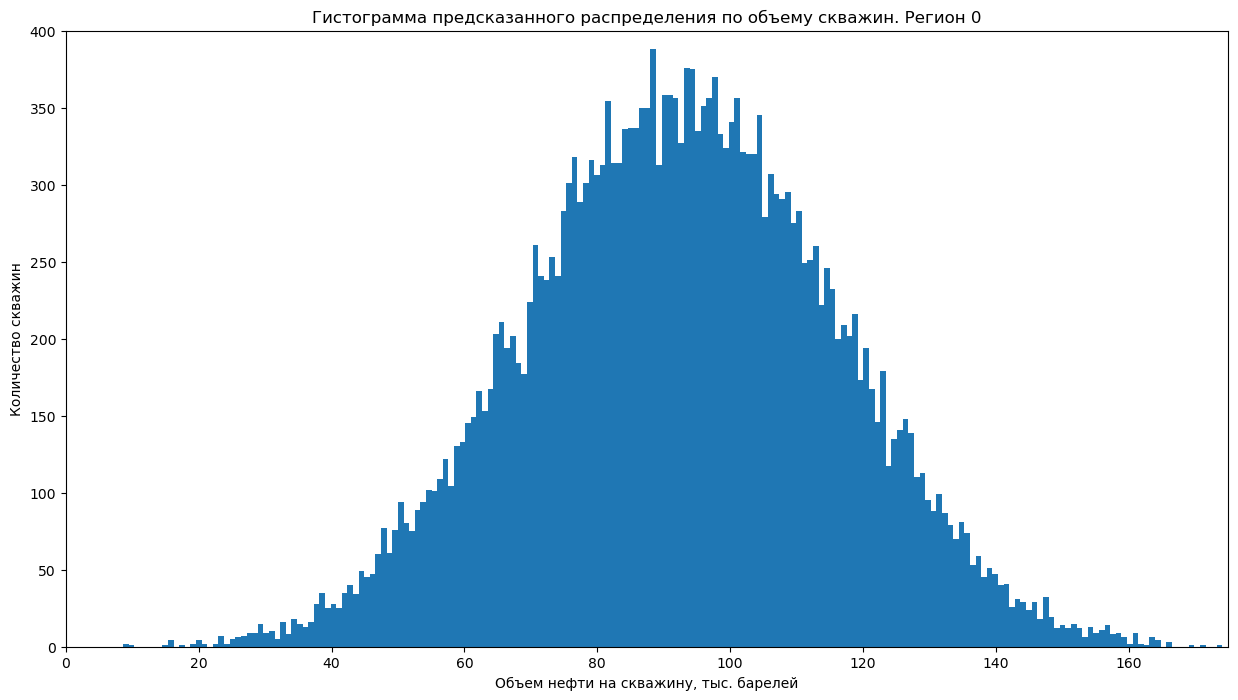

In [32]:
hist_oil(df_0_predicted['Product (Predicted)'], 200, 175, 400, 
         'Гистограмма предсказанного распределения по объему скважин. Регион 0')

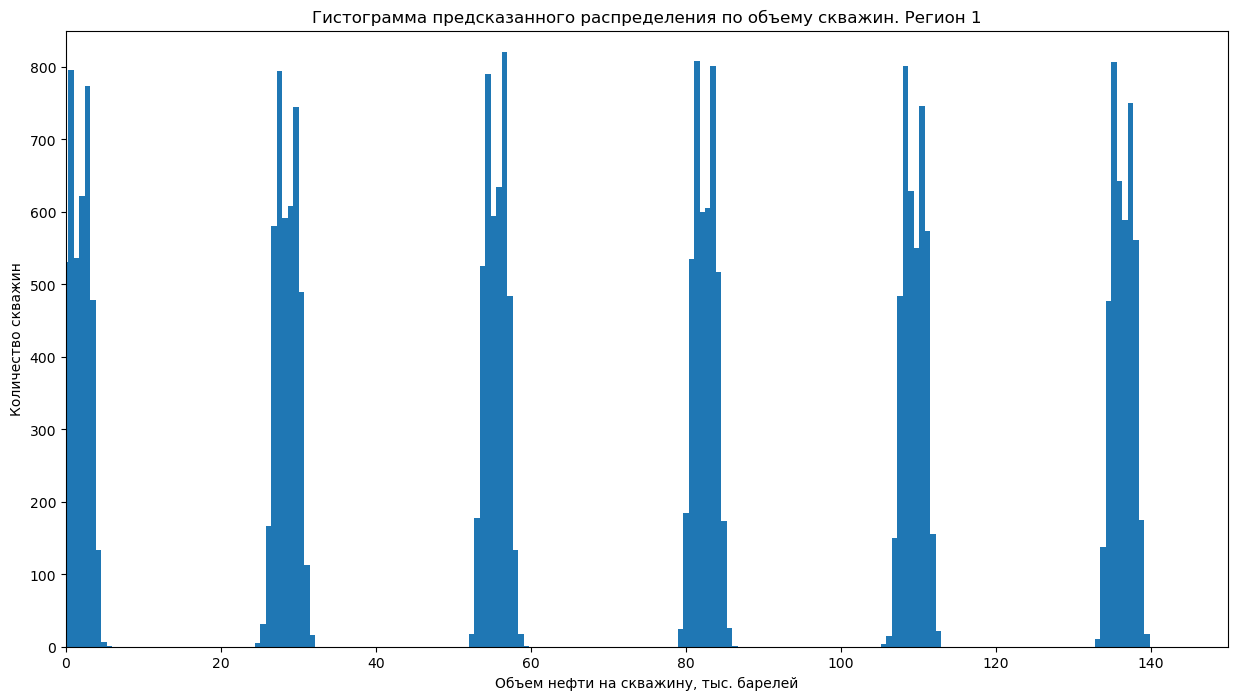

In [33]:
hist_oil(df_1_predicted['Product (Predicted)'], 200, 150, 850,
         'Гистограмма предсказанного распределения по объему скважин. Регион 1')

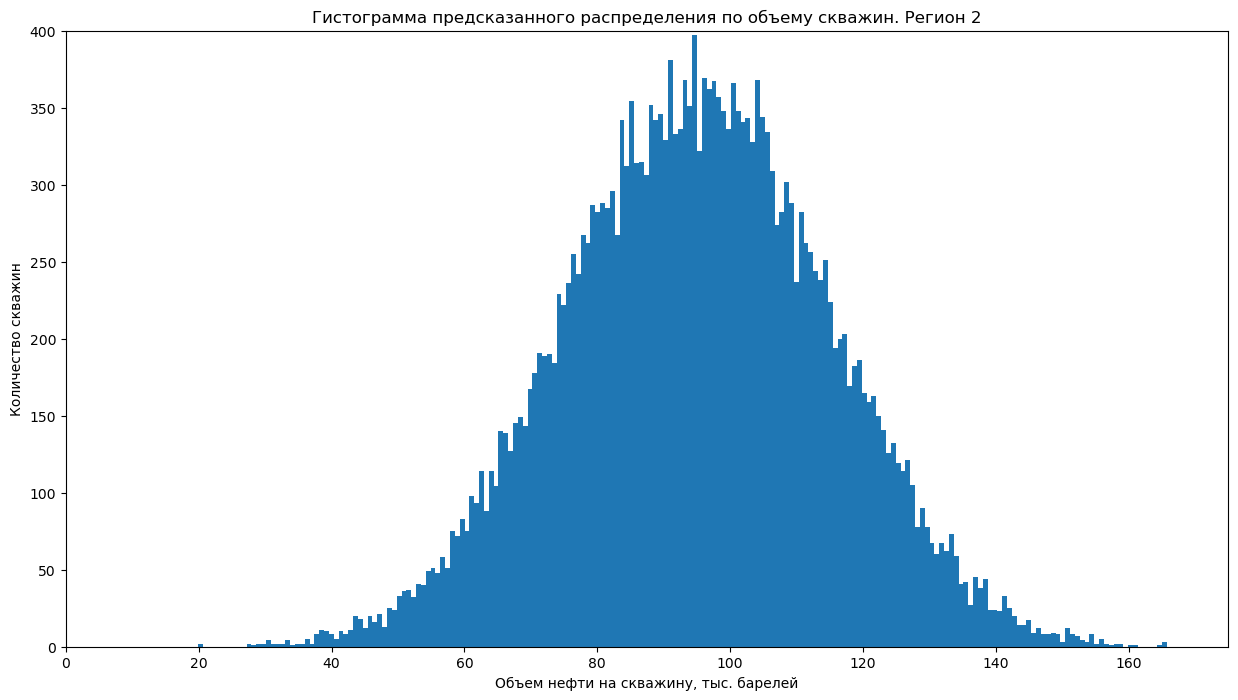

In [34]:
hist_oil(df_2_predicted['Product (Predicted)'], 200, 175, 400,
         'Гистограмма предсказанного распределения по объему скважин. Регион 2')

**Вывод:**

Была подготовлена средняя оценка прибили за скважину и средний объем на скважину.

Анализ средних объемов на скважину для каждого региона следующий:
- для региона 0 - 92.4391
- для региона 1 - 69.194
- для региона 2 - 94.9592

Изучены средние фактические запасы:
- Для регионов 0 и 2 - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего.
- В данных региона 1 достаточно много значений больше 111 и при определенной доли везения можно выбрать только лучшие в этой выборке, хотя и среднее значение 68.8.

Создана функция по расчету прибыли.

<a id=6></a>
[Содержание](#0)
## 6. Расчёт прибыли и рисков

Создадим функцию для расчета приыли на 500 разведанных точек

In [35]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending = False)
    selected = target[probs_sorted.index][:count]
    return PRICE_BARREL * selected.sum() - BUDGET

In [36]:
state = np.random.RandomState(RND_STATE)

def bootstrap_n(target, probs, count):
    values = []

    for i in range(count):
        target_sample = target.sample(replace = True, random_state=state, n = CHOSEN_POINTS)
        probs_sample = probs[target_sample.index]
        profit = revenue(target_sample, probs_sample, BEST_POINTS)
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = (values < 0).mean()

    print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average))
    print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower, upper))
    print('Процент риска = {:.2%}'.format(risk))
    print()

    return # average, lower, upper, risk

In [37]:
print('Регион 0')
# average_0, lower_0, upper_0, risk_0 = 
bootstrap_n(df_0_predicted['Product (Real)'], df_0_predicted['Product (Predicted)'], 1000)

print('Регион 1')
bootstrap_n(df_1_predicted['Product (Real)'], df_1_predicted['Product (Predicted)'], 1000)

print('Регион 2')
bootstrap_n(df_2_predicted['Product (Real)'], df_2_predicted['Product (Predicted)'], 1000)

Регион 0
Средняя прибыль по региону = 442510.66 тыс.руб.
95% доверительный интервал от -109240.18 до 951892.73 тыс.руб.
Процент риска = 5.70%

Регион 1
Средняя прибыль по региону = 510139.37 тыс.руб.
95% доверительный интервал от 112333.80 до 919401.52 тыс.руб.
Процент риска = 0.50%

Регион 2
Средняя прибыль по региону = 420842.08 тыс.руб.
95% доверительный интервал от -152448.65 до 972414.81 тыс.руб.
Процент риска = 7.10%



**Вывод:**

Данные были обработаны и рассчитаны для каждого региона прибыль, доверительный интервал и риск.

Мы отсеиваем регионы 0 и 2, так как риски достаточно велики.

Остается регион 1, чей риск ниже требуемого.

Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится.

<a id=7></a>
[Содержание](#0)
## 7. Общий вывод

#### Было выполнено:

- Изучены данные и подготлены к моделированию.

- Обучены модели для каждого региона.

- Составлена функция расчета прибыли в регионе.

- Посчитана прибыль и риски за каждый регион, обоснован выбор региона.

Добывающей компании «ГлавРосГосНефть» нужно бурить новую скважину в регионе 1.

Для регионов 0 и 2 риски достаточно велики.

Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин в регионе 1 окупится.